In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader 
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("/kaggle/working/")

In [3]:
class CNNBLock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=stride, padding=1, padding_mode='reflect'),
        nn.LeakyReLU(0.2),
        nn.BatchNorm2d(out_channels)
        ) 
        
    def forward(self, x):
        return self.conv(x)
    
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features = [64, 128, 256, 512]): # 256 -> 3
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2, out_channels=features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBLock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature
            
        layers.append( nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"),
            )
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, y):
        x = torch.cat([x, y], dim = 1)
        x = self.initial(x)
        return self.model(x)
  


class BLock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1, padding_mode='reflect')
            if down
            else nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU if act == 'relu' else nn.LeakyReLU(0.2),
            nn.BatchNorm2d(out_channels)
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x
    
        
class Generator(nn.Module):
    def __init__(self, in_channels=3, features = 64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.LeakyReLU(0.2),
        )
        
        self.down1 = BLock(features, features*2, down=True, act='leaky', use_dropout=False) #64
        self.down2 = BLock(features*2, features*4, down=True, act='leaky', use_dropout=False) #32
        self.down3 = BLock(features*4, features*8, down=True, act='leaky', use_dropout=False) #16
        self.down4 = BLock(features*8, features*8, down=True, act='leaky', use_dropout=False) #8
        self.down5 = BLock(features*8, features*8, down=True, act='leaky', use_dropout=False) #4
        self.down6 = BLock(features*8, features*8, down=True, act='leaky', use_dropout=False) #2
        
    
        self.bottleneck = nn.Sequential(
            nn.Conv2d(in_channels=features*8, out_channels=features*8, kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            nn.ReLU()
        )
        
        self.up1 = BLock(features*8, features*8, down=False, act='leaky', use_dropout=True) 
        self.up2 = BLock(features*8*2, features*8, down=False, act='leaky', use_dropout=True) 
        self.up3 = BLock(features*8*2, features*8, down=False, act='leaky', use_dropout=True) 
        self.up4 = BLock(features*8*2, features*8, down=False, act='leaky', use_dropout=False) 
        self.up5 = BLock(features*8*2, features*4, down=False, act='leaky', use_dropout=False) 
        self.up6 = BLock(features*4*2, features*2, down=False, act='leaky', use_dropout=False) 
        self.up7 = BLock(features*2*2, features, down=False, act='leaky', use_dropout=False) 
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features*2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7], 1))
        up3 = self.up3(torch.cat([up2, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [4]:
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset

In [5]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [6]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LR = 2e-4
BS = 64
NUM_WORKERS = 1
IMG_SZ = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
NUM_EPOCHS = 500
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_DISC = "my_checkpoint_disc.pth.tar"
CHECKPOINT_GEN = "my_checkpoint_gen.pth.tar"


In [7]:
both_transform = A.Compose(
        [
            A.Resize(256, 256),
            A.HorizontalFlip(p=0.5)
        ],
    additional_targets = {"image0":"image"},
)

transform_only_input = A.Compose(
        [
            A.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255.0),
            ToTensorV2(),
        ],
)

transform_only_mask = A.Compose(
        [
            A.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5], max_pixel_value=255.0),
            ToTensorV2(),
        ],
)


In [8]:
class MapDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.list_files = os.listdir(root_dir)
        
    def __len__(self):
        return len(self.list_files)
    
    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        img = np.array(Image.open(img_path))
        
        input_image = img[:, :256, :]
        target_image = img[:, 256:, :]
        
        augmentations = both_transform(image=input_image, image0=target_image)
        input_image, target_image = augmentations["image"], augmentations["image0"]
        input_image, target_image = transform_only_input(image=input_image)["image"], transform_only_mask(image=target_image)["image"]
        
        return input_image, target_image
    

In [9]:
from torchvision.utils import save_image

def save_some_examples(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5
        save_image(y_fake, folder + f"/y_gen_{epoch}.png")
        save_image(x * 0.5 + 0.5 , folder + f"/input_{epoch}.png")
        if epoch == 1:
            save_image(y * 0.5 + 0.5 , folder + f"label_{epoch}.png")
        
    gen.train()
    
def show_some_examples(gen, val_loader):
    x, y = next(val_loader)
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()

    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5
        x = x * 0.5 + 0.5
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (20, 5))
        axes[0].imshow(x[0].cpu().permute(1,2,0).numpy())
        axes[0].axis("off")
        axes[1].imshow(y_fake[0].cpu().permute(1,2,0).numpy())
        axes[1].axis("off")
        axes[2].imshow(y[0].cpu().permute(1,2,0).numpy())
        axes[2].axis("off")
        plt.show()
        
    gen.train()
    

    
def save_checkpoint(model, optimizer, filename = "my_checkpoint.pth.tar"):
    print("=> Saving Checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    
def load_checkpoint(file, model, optimizer):
    print("=> Loading Ckechpoint")
    checkpoint = torch.load(file, map_location = DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    

In [17]:
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1, bce):
    loop = tqdm(loader, leave=False)
    #loop = loader
    
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            d_real = disc(x,y)
            d_fake = disc(x, y_fake.detach())
            
            d_real_loss = bce(d_real, torch.ones_like(d_real))
            d_fake_loss =  bce(d_fake, torch.zeros_like(d_fake))
            d_loss = (d_real_loss + d_fake_loss) / 2
            
        disc.zero_grad()
        d_loss.backward()
        opt_disc.step()
        
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            '''
            There shouldn't be y.fake.detach(), but i have trained with it, and so i have trained only part responsible for good pixel-pixel reconstruction
            ------------------
            d_fake = disc(x, y_fake.detach())
            -------------------
            '''
            d_fake = disc(x, y_fake)
            g_loss = bce(d_fake, torch.ones_like(d_fake)) + l1(y, y_fake) * L1_LAMBDA
            
        gen.zero_grad()
        g_loss.backward()
        opt_gen.step()


In [18]:
disc = Discriminator(in_channels=3).to(DEVICE)
gen = Generator(in_channels=3, features=64).to(DEVICE)
opt_disc = torch.optim.Adam(disc.parameters(), lr=LR, betas=(0.5, 0.999),)
opt_gen = torch.optim.Adam(gen.parameters(), lr=LR, betas=(0.5, 0.999))
BCE = torch.nn.BCEWithLogitsLoss()
L1_LOSS = torch.nn.L1Loss()

In [12]:
if LOAD_MODEL:
    load_checkpoint(CHECKPOINT_GEN, gen, opt_gen)
    load_checkpoint(CHECKPOINT_DISC, disc, opt_disc)
    

=> Loading Ckechpoint
=> Loading Ckechpoint


In [19]:
train_dataset = MapDataset(root_dir="/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/train")
val_dataset = MapDataset(root_dir="/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val")
train_loader = DataLoader(train_dataset, batch_size = BS, shuffle = True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False)
val_loader = iter(val_loader) 

  0%|          | 0/778 [00:00<?, ?it/s]

=> Saving Checkpoint
=> Saving Checkpoint
0


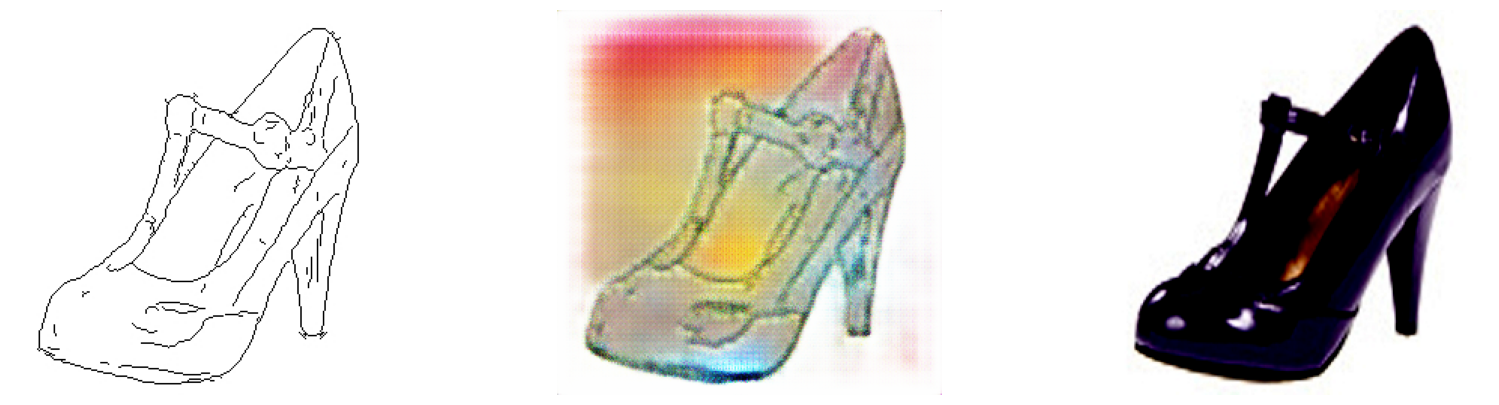

  0%|          | 0/778 [00:00<?, ?it/s]

=> Saving Checkpoint
=> Saving Checkpoint
1


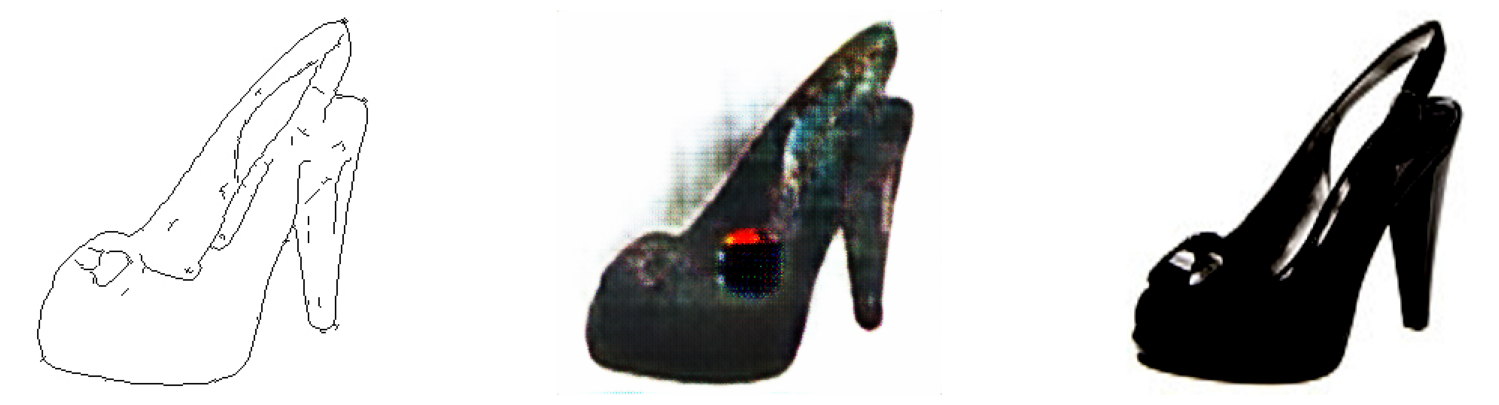

  0%|          | 0/778 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
for epoch in range(NUM_EPOCHS):
    train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE)
    
    if SAVE_MODEL and epoch % 1 == 0:
        save_checkpoint(disc, opt_disc, CHECKPOINT_DISC)
        save_checkpoint(gen, opt_gen, CHECKPOINT_GEN)
        
    if epoch % 1 == 0: 
        print(epoch)
        #save_some_examples(gen, val_loader, epoch, folder="/kaggle/working/")
        show_some_examples(gen, val_loader)

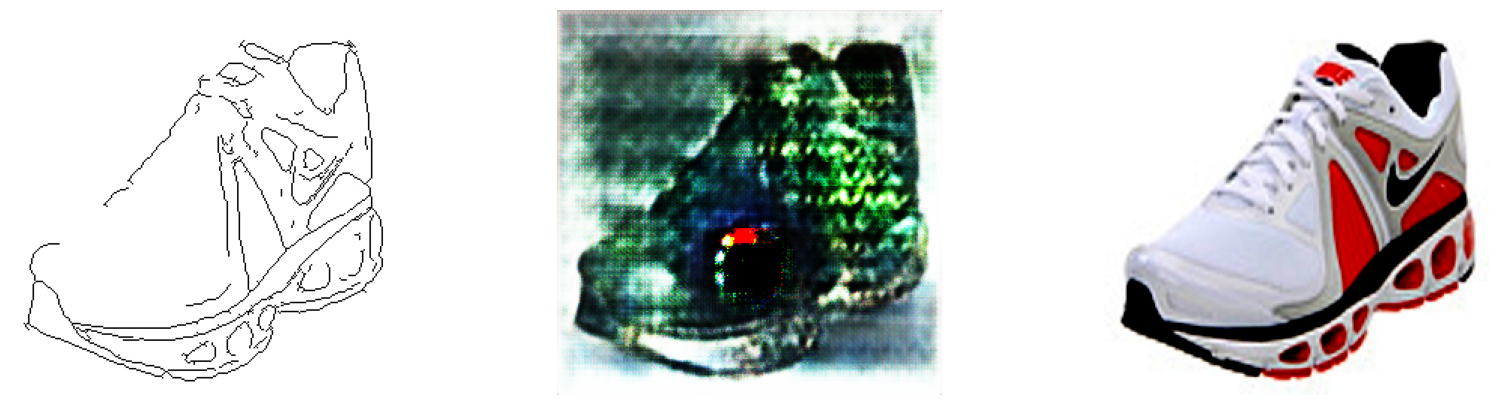

In [24]:
show_some_examples(gen, val_loader)